In [1]:
# Libraries needed
import json
import requests
import pandas as pd
import numpy as np

from alpha_vantage.cryptocurrencies import CryptoCurrencies
import asyncio
from alpha_vantage.async_support.timeseries import TimeSeries
from alpha_vantage.timeseries import TimeSeries

import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

from sklearn import preprocessing

import time
import datetime
import sys
import time

# from pprint import pprint
# from bs4 import BeautifulSoup

class stock_ml:
    #Initialise the model
    def __init__(self,low_cap_stock):
        # Call the key for AlphaVantage
        ky = pd.read_csv('AVk.txt',names='A')
        self.k = ky.iloc[0][0]
        
        # Initialize the variables needed for TimeSeries to make the API requests
        self.ts = TimeSeries(key=self.k, output_format='pandas')
        self.url = "https://alpha-vantage.p.rapidapi.com/query"
        self.headers = {
            'x-rapidapi-host': "alpha-vantage.p.rapidapi.com",
            'x-rapidapi-key': self.k
            }
        self.slices = ['year1month1','year1month2','year1month3','year1month4','year1month5','year1month6']
#         self.slices = ['year1month1','year1month2']
        self.cols = ['time', 'open', 'high', 'low', 'close', 'volume']
        
        # Define groups of stocks/cryptos to gather historical data through Alpha Vantage API 
        self.lc_stocks= low_cap_stock
        print(type(self.lc_stocks))
        self.tech_stocks=['MSFT','TSLA','AMZN','AAPL','GOOG','FB']
        self.bank_stocks=['JPM','BAC','WFC','C','GS']
        self.cryptos=['BTC','ETC','ETH','XRP','XLM','TRX']
        pass
    
    # Function to return best matching symbols on the stock market, giving an output based on the keyword
    def search_company(self,word):
        search = self.ts.get_symbol_search(keywords=word)
        search[0].index = search[0].index.astype(int)
        finding = search[0][['1. symbol','2. name','3. type','4. region','8. currency','9. matchScore']]
        return finding
    
    # Function to look for historical data of the symbol sent
    def get_stock_price(self,stock_interval,stock_size):
        # stock_interval:'1min', '5min', '15min'(default), '30min', '60min'
        # stock_size: 'full', 'compact'(default)
        print(self.lc_stocks)
        new_list=[]
        a = 0
        for l_stock in self.lc_stocks:
            for stock_intraday in self.slices:
                querystring = {"datatype":"csv","slice":stock_intraday,"interval":stocks_interval,"function":"TIME_SERIES_INTRADAY_EXTENDED","symbol":l_stock}
                response = requests.request("GET", self.url, headers=self.headers, params=querystring)
                
                #If we got a 429 response, we will sleep the program for 60 seconds, then continue the requests
                if response.status_code == 429:
                    print(a,"\nTime to sleep 60 sec, too much activity!!")
                    while response.status_code != 200:  
                        for i in range(60,0,-1):
                            sys.stdout.write(str(i)+' ')
                            sys.stdout.flush()
                            time.sleep(1)
                        response = requests.request("GET", self.url, headers=self.headers, params=querystring)
                        print(response)
                
                #Data cleaning from the request to return a clean dataframe
                clean_string = response.text.replace('\r\n',',')
                price_list = clean_string.split(sep=",")
                new_list = [price_list[i:i+6] for i in range(0, len(price_list), 6)]
                df_temp = pd.DataFrame(new_list[1:],columns=self.cols)
                df_temp['company'] = l_stock
                
                if a==0:
                    df_row = df_temp[['time','open','volume','company']]
                    a+=1
                    
                else:
                    df_row = pd.concat([df_row,df_temp],join='inner',ignore_index=True) #Index restarts for every new block added
                    a+=1
                    
                df_row.dropna(inplace=True)
                print(f'Slice {stock_intraday} completed succesfully: {l_stock}. You got so far {len(df_row)} rows.')        
        
        df_row['time']=pd.to_datetime(df_row['time'])
        df_row['open']=pd.to_numeric(df_row['open'],downcast='float')
        df_row['volume']=pd.to_numeric(df_row['volume'],downcast='float')
        df_row['company']=df_row['company'].astype(str)
        return df_row

In [ ]:
# lc_stock = ['RIG','SHLO','NBR','INO','PTEN','HTZ','COMM','IVR','CDE','MUX','AMC','CBL','IAG','HEXO','ACB','CLNY','TLRY','FRO','VRTU','WTRH','APHA','FIT','EXK','TGI','SNDL'
#             ,'TWO','SPRO','HMHC','MGY','HP','ERJ','PTY','CPG','ZYME','ENLC','TEN','EXPR','SUM','GERN','ETM','PEB','LC','ACOR','EHTH','FET','EVH','BITA']
# lc_stock = ['AVYA','JKS','CCO','KDMN','INSG','BIG','CHS','GPRO','BEST','GEL','MBI','PRTS','OII','LUB','TTMI','GOL','KIRK','UXIN','EGHT','DXLG','ORC','OXLC','KYN','AHT','BLU']
# lc_stock = ['TTI','SPWH','EXTR','ATSG','RPT','AXL','OIS','FLWS','MWA','RST','DRNA','REPL','JRO','UE','ABUS','PFL','HBM','PLT','YEXT']
# lc_stock= ['UIS','XBIT','VHC','TTMI','TGH','ICHR','NVAX','PRTS']
# lc_stock= ['CODX']

In [2]:
# lc_stock = ['CODX','UIS','XBIT','VHC','TTMI','TGH','ICHR','NVAX','PRTS','TTI','SPWH','EXTR','ATSG','RPT','AXL','OIS','FLWS','MWA','RST','DRNA','REPL','JRO','UE','ABUS','PFL','HBM','PLT','YEXT']
lc_stock = ['CODX','UIS','XBIT','VHC','TTMI','TGH','ICHR','NVAX','PRTS','TTI','SPWH','EXTR']
s = stock_ml(lc_stock)

<class 'list'>


In [ ]:
# Ranges for differente intervals
# '5min', size=432 (36hrs),step=48 (4hrs) 
# '5min', size=192 (16hrs),step=24 (2hrs)
# '1min', size=960 (16hrs),step=40 (0.67hrs)
# '1min', size=480 (8hrs),step=5 (0.08hrs)
# '1min', size=240 (4hrs),step=4 (0.07hrs)

stocks_interval = '5min'
stocks_size = 'full'
stock_historian = s.get_stock_price(stocks_interval,stocks_size)
# stock_historian.info()

# Reset index and order dataframe for ML
stock_history = stock_historian.copy(deep=True)
stock_history.set_index('time',inplace=True)
stock_history.rename_axis("index",inplace=True)
stock_history.sort_values(by=['company','index'],ascending = [False, True],inplace=True)

In [ ]:
stock_history

In [ ]:
# stock_history.to_csv("small_cap.csv")

In [3]:
stock_history = pd.read_csv('small_cap_2.csv')

In [ ]:
# stock_history[stock_history['company']=='CODX']

In [4]:
# Make slices of comparable data, then normalize it and calculate the metrics to select patterns to look for, according to the benefit amount
size = 432
step = 48
stock_lists = []
stock_norm = pd.DataFrame()

metrics = pd.DataFrame(columns=['M1','M2','M3','M4','maxi','maxi_index','mini','mini_index','mean','moda',
                                'first','index_start','last','index_last'],dtype=np.float)

# Cut data in slices
for name in lc_stock:
    stock_lists_temp = [stock_history[stock_history['company']==name][['open','company']][i:i+size] for i in 
                        range(0, len(stock_history[stock_history['company']==name][['open']]), step) if 
                        len(stock_history[stock_history['company']==name][['open','company']][i:i+size])==size]
    stock_lists = stock_lists + stock_lists_temp
    
    print(name,': ',len(stock_lists))


CODX :  345
UIS :  544
XBIT :  731
VHC :  935
TTMI :  1136
TGH :  1327
ICHR :  1524
NVAX :  1892
PRTS :  2090
TTI :  2372
SPWH :  2582
EXTR :  2789


In [5]:
# Normalize
for a in stock_lists:
    a['normalized'] = (a['open']-a['open'].min())/(a['open'].max()-a['open'].min())

In [6]:
stock_lists[1400].loc[97680]

open              21.44
company            ICHR
normalized    0.0340426
Name: 97680, dtype: object

In [7]:
X = []
y = []
for i in range(0,len(stock_lists)):
    X.append(list(stock_lists[i]['normalized']))
    y.append(stock_lists[i].iloc[0,1])


In [ ]:
# stock_lists[0].iloc[0]

In [8]:
df_X = pd.DataFrame(X)
df_X.dropna(inplace=True)

In [9]:

index = df_X.index
df_y = pd.DataFrame(y)
df_y = df_y.loc[index]

In [ ]:
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, gen_min_span_tree=False)
clusterer.fit(np.array(df_X))
clusterer.labels_
df = pd.concat([df_X,df_y],axis=1)
df['label'] = clusterer.labels_
# df.groupby('label').aggregate({0:'count'})

In [ ]:
df.groupby('label').count()[1]

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(np.array(df_X))
distances, indices = nbrs.kneighbors(np.array(df_X))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
m = DBSCAN(eps=0.3, min_samples=5)
m.fit(np.array(df_X))
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(df_X[:,0], df_X[:,1], c=vectorizer(clusters))


In [10]:
metrics

,M1,M2,M3,M4,maxi,maxi_index,mini,mini_index,mean,moda,first,index_start,last,index_last


In [11]:
# Define metrics to measure 
metrics = pd.DataFrame(columns=['M1','M2','M3','M4','maxi','maxi_index','mini','mini_index','mean','moda',
                                'first','index_start','last','index_last'],dtype=np.float)
for a in stock_lists:
    maxi = a['open'].max()
    maxi_index = a['open'].idxmax()
    mini = a['open'].min()
    mini_index = a['open'].idxmin()
    means = a['open'].mean()
    moda = a['open'].mode()[0]
    index_start = a.index.min()
    index_end = a.index.max()
    firsts = a.loc[index_start][0]
    lasts = a.loc[index_end][0]
    metric1 = (maxi/mini) - 1
    metric2 = metric1 + (1 - abs(means / firsts))
    metric3 = metric1 + (1 - abs(means / lasts))
    metric4 = metric1 + ((means-moda) / means)
    metrics.loc[len(metrics)] = [metric1,metric2,metric3,metric4,maxi,maxi_index,mini,mini_index,means,moda,firsts,index_start,lasts,index_end]
#     metrics.loc[len(metrics)] = [metric1,metric2,metric3,metric4]

# print(maxi,mini,mean,first,last,moda)
# print(metric1,metric2,metric3)

M1    0.242315
M2    0.224113
M3    0.249396
M4    0.250235
dtype: float64


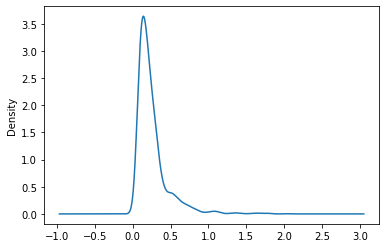

In [12]:
# Plot different metrics to select one
print(metrics[['M1','M2','M3','M4']][0:].mean())
metrics['M4'].plot(kind='kde')

2213 2.0475815856686865


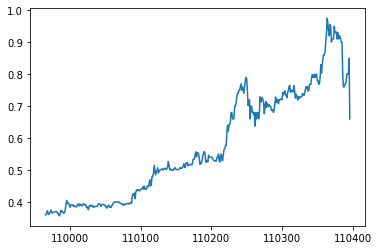

In [13]:
print(metrics['M4'].idxmax(),metrics['M4'].max())
stock_lists[metrics['M4'].idxmax()]['open'].plot()

146


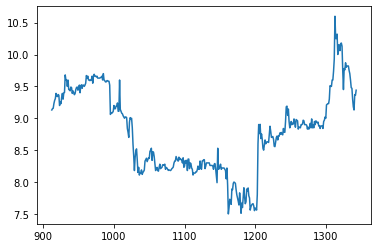

M1    0.413333
M2    0.451577
M3    0.483160
M4    0.479482
Name: 19, dtype: float64


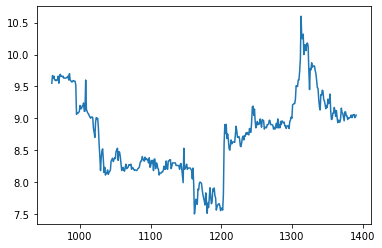

M1    0.413333
M2    0.497592
M3    0.446999
M4    0.475690
Name: 20, dtype: float64


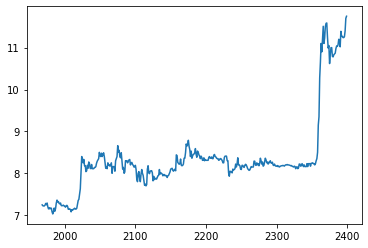

M1    0.671408
M2    0.519077
M3    0.960846
M4    0.694058
Name: 41, dtype: float64


In [14]:
# Define patterns that comply with the metrics stablished, to get benefit in the stock transaction

index_pattern = []
index_pattern_bull = metrics['M4'][(metrics['M4']>.4) & ((metrics['maxi_index']-metrics['index_start'])>(size*0.8))].index
index_pattern_bear = metrics['M4'][(metrics['M4']>.4) & ((metrics['mini_index']-metrics['index_start'])>(size*0.8))].index
# index_pattern_bull = metrics['M4'][(metrics['M4']>.4) & (metrics['M4']<.7) & ((metrics['maxi_index']-metrics['index_start'])>(size*0.85))].index
# index_pattern_bear = metrics['M4'][(metrics['M4']>.4) & (metrics['M4']<.7) & ((metrics['mini_index']-metrics['index_start'])>(size*0.85))].index
# index_pattern = index_pattern_bull.values[0:-2] + index_pattern_bear.values[0:-2]

for ai in index_pattern_bear:
    index_pattern.append(ai) 
for ai in index_pattern_bull:
    index_pattern.append(ai)
# print(index_pattern)

print(len(index_pattern_bull))
for a in index_pattern_bull[0:3]:
    stock_lists[a]['open'].plot()
    plt.show()
    print(metrics.iloc[a][['M1','M2','M3','M4']])
    

194


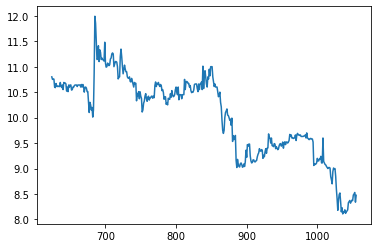

M1    0.478568
M2    0.549254
M3    0.294298
M4    0.422442
Name: 13, dtype: float64


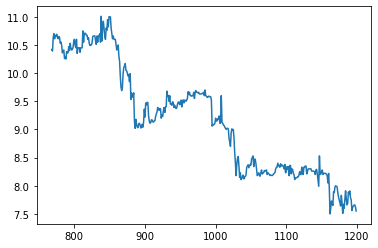

M1    0.468000
M2    0.588431
M3    0.254288
M4    0.573302
Name: 16, dtype: float64


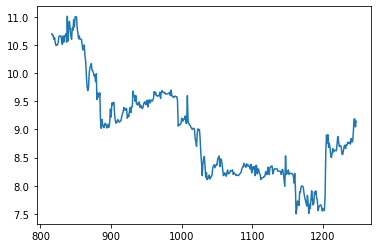

M1    0.468000
M2    0.630600
M3    0.488188
M4    0.552840
Name: 17, dtype: float64


In [15]:
print(len(index_pattern))
for a in index_pattern[0:3]:
    stock_lists[a]['open'].plot()
    plt.show()
    print(metrics.iloc[a][['M1','M2','M3','M4']])


In [17]:
# # stock_lists[12].iloc[0][0]
# end = round(size*.8)
# # stock_lists_temp_X
# stock_lists_X = []
# for stock_X in lc_stock:
    
#     stock_lists_temp_X = [stock_history[stock_history['company']==name][['open','company']][i:i+size] for i in 
#                         range(0, len(stock_history[stock_history['company']==name][['open']]), step)]
#     stock_lists_X = stock_lists_X + stock_lists_temp_X

In [18]:
end = round(size*.8)
Stock_X = []
Stock_y = []
for a in range(0,len[stock_lists]):
    Stock_X.append(list(stock_lists[a].loc[metrics[a].loc['index_start']:(metrics[a].loc['index_start'] + end)]['open']))
    if b in index_pattern:
        Stock_y.append(metrics.loc[a]['M4'])
    else:
        Stock_y.append(0)
    
df_Stock_X = pd.DataFrame(Stock_X)
df_Stock_X.dropna(inplace=True)
# index = df_X.index
df_Stock_y = pd.DataFrame(Stock_y)
# df_y = df_y.loc[index]

TypeError: 'builtin_function_or_method' object is not subscriptable

In [ ]:
metrics.loc[0]['M4']

In [ ]:
stock_lists[8].loc[384:390]

In [ ]:
i = 0


# stock_lists[1400].loc[97680]

# If min_pi < max_pi then max, end_pi - max_pi
# If min_pi < max_pi then min, end_pi - min_pi

#### Appendix A: Test for different functions

In [ ]:
### API AV request

# ky = pd.read_csv('AVk.txt',names='A')
# kx = ky.iloc[0][0]
# urlx = "https://alpha-vantage.p.rapidapi.com/query"
# headersx = {
#             'x-rapidapi-host': "alpha-vantage.p.rapidapi.com",
#             'x-rapidapi-key': kx
#             }
# sym='CODX'
# querystring = {"datatype":"csv","interval":stocks_interval,"slice":"year1month5","function":"TIME_SERIES_INTRADAY_EXTENDED","symbol":sym}
# response = requests.request("GET", urlx, headers=headersx, params=querystring)

# clean_string = response.text.replace('\r\n',',')
# price_list = clean_string.split(sep=",")
# new_list = [price_list[i:i+6] for i in range(0, len(price_list), 6)]
# df_temp = pd.DataFrame(new_list[1:],columns=['time', 'open', 'high', 'low', 'close', 'volume'])
# df_temp['company'] = sym
# df_temp

In [ ]:
### API AV search
# stock_ml.search_company('tech')

In [ ]:
### Graph Stock price and stock on the same item

# #Define window to graph prices and volume
# stock_graph_start = 0
# stock_graph_end = 432
# stock_bucket_step = 48

# #Create figure and axis objects with subplots()
# fig,ax = plt.subplots(figsize=(20,5))
# #Make a plot
# ax.plot(stock_historian[stock_graph_start:stock_graph_end].index, stock_historian[stock_historian['company']=="VHC"][['open']][stock_graph_start:stock_graph_end], color="red", marker=".")
# #Set x-axis label
# ax.set_xlabel("TimeFrame",fontsize=14)
# #Set y-axis label
# ax.set_ylabel("Price",color="red",fontsize=14)
# #Next we use twinx() function to create the second axis object “ax2”. Now we use the second axis object “ax2” to make plot of the second y-axis variable and update their labels.

# #Twin object for two different y-axis on the sample plot
# ax2=ax.twinx()
# #Make a plot with different y-axis using second axis object
# ax2.plot(stock_historian[stock_graph_start:stock_graph_end].index, stock_historian[stock_historian['company']=="VHC"][['volume']][stock_graph_start:stock_graph_end],color="blue",marker=".")
# ax2.set_ylabel("Volume",color="blue",fontsize=14)
# plt.show()
# # save the plot as a file
# fig.savefig('Price_vs_Volume.png',
#             format='png',
#             dpi=500,
#             bbox_inches='tight')
# # plt.show()

In [ ]:
### Graph Stocks time series without blank spaces on no trading days

# def plot_ts(ts, step=5, figsize=(10,7), title=''):
#     """
#     plot timeseries ignoring date gaps

#     Params
#     ------
#     ts : pd.DataFrame or pd.Series
#     step : int, display interval for ticks
#     figsize : tuple, figure size
#     title: str
#     """

#     fig, ax = plt.subplots(figsize=figsize)
#     ax.plot(range(ts.dropna().shape[0]), ts.dropna())
#     ax.set_title(title)
#     ax.set_xticks(np.arange(len(ts.dropna())))
#     ax.set_xticklabels(ts.dropna().index.tolist());

#     # tick visibility, can be slow for 200,000+ ticks 
#     xticklabels = ax.get_xticklabels() # generate list once to speed up function
#     for i, label in enumerate(xticklabels):
#         if not i%step==0:
#             label.set_visible(False)  
#     fig.autofmt_xdate()

# plot_ts(stock_history[stock_history['company']=="CODX"][['open']][432:864],20)